# Classification model on the MNIST data set

## Import packages and load the MNIST data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
mnist = fetch_openml('mnist_784', version = 1, cache = True, as_frame = False)

C:\Users\adria\anaconda3\envs\ML2\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

### Splitting the data into train, val and test sets

In [4]:
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=10000, random_state=42)

In [6]:
#creating a smaller data set for hyper parameter tuning
X_train_small, _, y_train_small, _= train_test_split(X_train_full, y_train_full, train_size=10000, stratify=y_train_full, random_state=42)

### Creating a function that displays a confusion matrix

In [7]:
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

## EDA

In [8]:
#check the shape of the training data
print(f'The shape of X_train:', X_train.shape)
print(f'The shape of y_train:', y_train.shape)

The shape of X_train: (50000, 784)
The shape of y_train: (50000,)


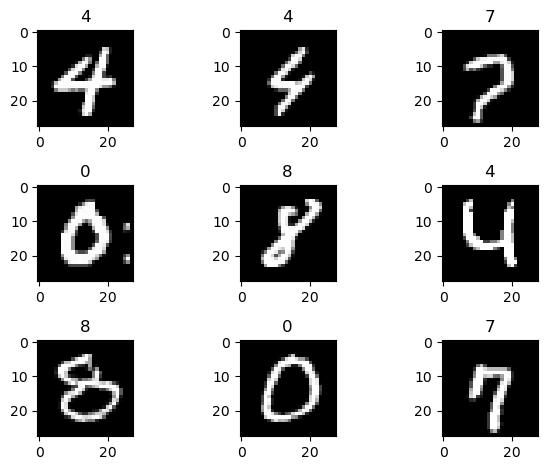

In [9]:
#compare some images with the target value
for i in range(9):
    plt.subplot(330 + 1 + i)
    image = X_train[i].reshape(28, 28)
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

plt.tight_layout()
plt.show()

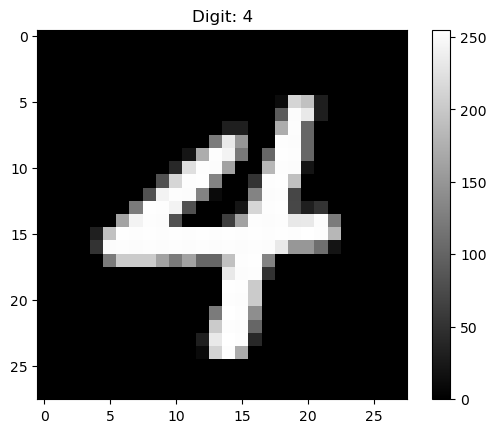

In [10]:
#plot a digit with a colorbar
image_index = 0 
plt.imshow(X_train[image_index].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.title(f'Digit: {y_train[image_index]}')
plt.show()

## Data preproccesing

In [11]:
#creating a pipeline for scaling and PCA
preprocess_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
])

In [12]:
#transofrm the train and validation data, as well as the smaller data set created
X_train_prepared = preprocess_pipe.fit_transform(X_train)
X_val_prepared = preprocess_pipe.transform(X_val)
print(X_train_prepared.shape)
print(X_val_prepared.shape)

(50000, 327)
(10000, 327)


In [13]:
X_train_small_prepared = preprocess_pipe.transform(X_train_small)
X_train_small_prepared.shape

(10000, 327)

## Models

### Logistic regression model

In [14]:
#Logistic Regression
log_reg_clf = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
log_reg_clf.fit(X_train_prepared, y_train)
log_pred = log_reg_clf.predict(X_val_prepared)

In [15]:
log_pred = log_reg_clf.predict(X_val_prepared)
print(classification_report(y_val, log_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       997
           1       0.95      0.97      0.96      1158
           2       0.92      0.90      0.91      1007
           3       0.92      0.87      0.89      1028
           4       0.91      0.94      0.92       966
           5       0.87      0.88      0.88       885
           6       0.93      0.95      0.94       945
           7       0.94      0.94      0.94      1070
           8       0.89      0.86      0.87       988
           9       0.89      0.89      0.89       956

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



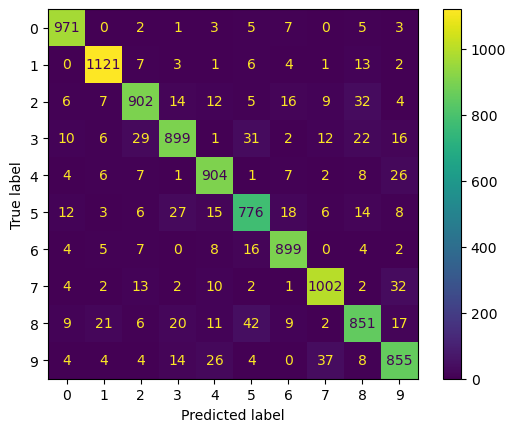

In [16]:
display_confusion_matrix(y_val, log_pred)

### SVC model

In [17]:
%%time

#SVC model
svm_clf = SVC()
#create parameter grid
param_grid = [
    {'kernel': ['rbf', 'poly'], 'gamma': [1, 2], 'C': [0.5, 1, 2]}
]
#use gridsearch on the smaller dataset created
svm_grid = GridSearchCV(svm_clf, param_grid)
svm_grid.fit(X_train_small_prepared, y_train_small)
print(svm_grid.best_params_)

{'C': 0.5, 'gamma': 1, 'kernel': 'poly'}
CPU times: total: 10min 6s
Wall time: 12min 8s


In [18]:
svm_tuned = SVC(kernel='poly', gamma=1, C=0.5)
svm_tuned.fit(X_train_prepared, y_train)
svm_pred = svm_tuned.predict(X_val_prepared)

In [19]:
print(classification_report(y_val, svm_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       997
           1       0.99      0.99      0.99      1158
           2       0.97      0.98      0.97      1007
           3       0.98      0.97      0.97      1028
           4       0.97      0.97      0.97       966
           5       0.98      0.98      0.98       885
           6       0.99      0.98      0.99       945
           7       0.98      0.98      0.98      1070
           8       0.97      0.97      0.97       988
           9       0.97      0.97      0.97       956

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



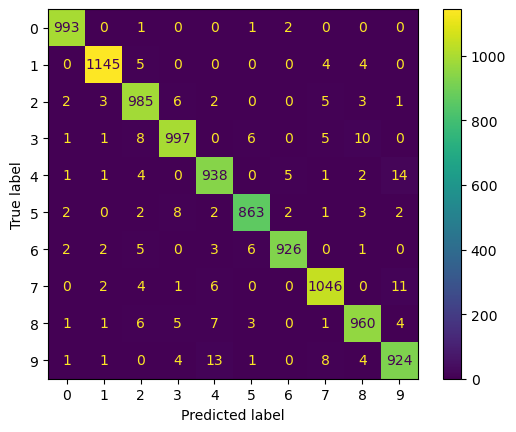

In [20]:
display_confusion_matrix(y_val, svm_pred)

### RandomForestClassifier model

In [27]:
%%time
#randomforestclassifier
random_forest_clf = RandomForestClassifier()
#create parameter grid
hyper_params = [
    {'n_estimators': [100, 300, 400], 'max_depth': [None, 50, 100]}
]
#use gridsearch to find best hyper parameters
random_forest_grid = GridSearchCV(random_forest_clf, hyper_params)
random_forest_grid.fit(X_train_small_prepared, y_train_small)
print(random_forest_grid.best_params_)

{'max_depth': 50, 'n_estimators': 300}
CPU times: total: 25min 41s
Wall time: 27min 54s


In [30]:
%%time
random_forest_tuned = RandomForestClassifier(max_depth=50, n_estimators=300)
random_forest_tuned.fit(X_train_prepared, y_train)
forest_pred = random_forest_tuned.predict(X_val_prepared)
print(classification_report(y_val, forest_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       997
           1       0.98      0.97      0.98      1158
           2       0.90      0.94      0.92      1007
           3       0.91      0.91      0.91      1028
           4       0.92      0.95      0.93       966
           5       0.93      0.91      0.92       885
           6       0.96      0.96      0.96       945
           7       0.94      0.94      0.94      1070
           8       0.95      0.90      0.92       988
           9       0.92      0.91      0.92       956

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

CPU times: total: 5min 51s
Wall time: 6min 34s


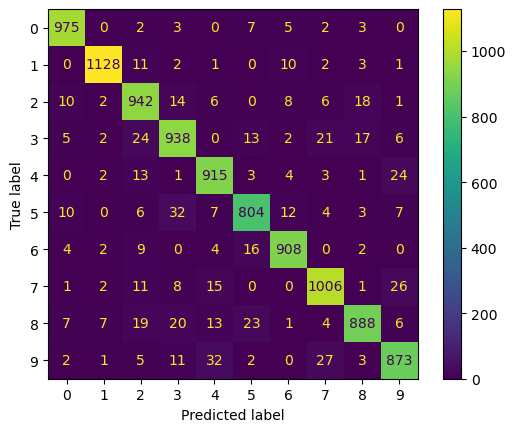

In [31]:
display_confusion_matrix(y_val, forest_pred)

### KNN classifier

In [32]:
%%time
#Nearest Neighbors
knn_clf = KNeighborsClassifier()
#param grid
params = [
    {'n_neighbors': [5, 10, 15, 20]}
]

knn_grid = GridSearchCV(knn_clf, params)
knn_grid.fit(X_train_small_prepared, y_train_small)
knn_grid.best_params_

CPU times: total: 45 s
Wall time: 4.51 s


{'n_neighbors': 5}

In [33]:
knn_tuned = KNeighborsClassifier(n_neighbors=5)
knn_tuned.fit(X_train_prepared, y_train)
knn_pred = knn_tuned.predict(X_val_prepared)
print(classification_report(y_val, knn_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       997
           1       0.96      0.99      0.98      1158
           2       0.94      0.94      0.94      1007
           3       0.95      0.93      0.94      1028
           4       0.94      0.94      0.94       966
           5       0.93      0.93      0.93       885
           6       0.96      0.97      0.97       945
           7       0.94      0.95      0.95      1070
           8       0.97      0.90      0.94       988
           9       0.92      0.93      0.92       956

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



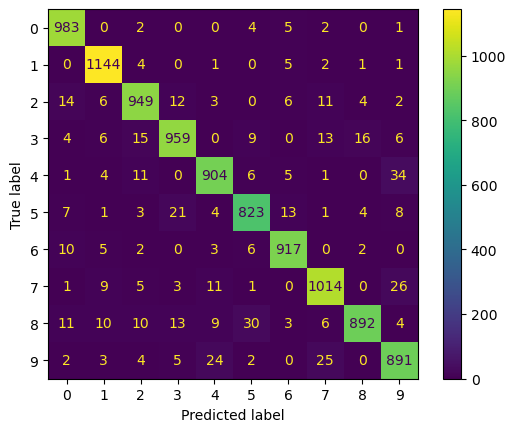

In [34]:
display_confusion_matrix(y_val, knn_pred)

## Evaluating chosen model on test set

The support vector machine performed the best so we will continue with that model

In [35]:
#prepare the full training data and the test data ( fit the pipeline again on the full training data)
X_train_full_prepared = preprocess_pipe.fit_transform(X_train_full)
X_test_prepared = preprocess_pipe.transform(X_test)
X_train_full_prepared.shape

(60000, 330)

In [38]:
%%time
svm_final = SVC(kernel='poly', gamma=1, C=0.5)
svm_final.fit(X_train_full_prepared, y_train_full)

CPU times: total: 2min 12s
Wall time: 2min 18s


SVC(C=0.5, gamma=1, kernel='poly')

In [39]:
test_pred = svm_final.predict(X_test_prepared)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       0.99      0.99      0.99      1152
           2       0.97      0.99      0.98       967
           3       0.97      0.97      0.97      1034
           4       0.97      0.98      0.97       906
           5       0.98      0.98      0.98       937
           6       0.99      0.99      0.99       961
           7       0.98      0.97      0.98      1055
           8       0.97      0.97      0.97       969
           9       0.97      0.96      0.96      1036

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



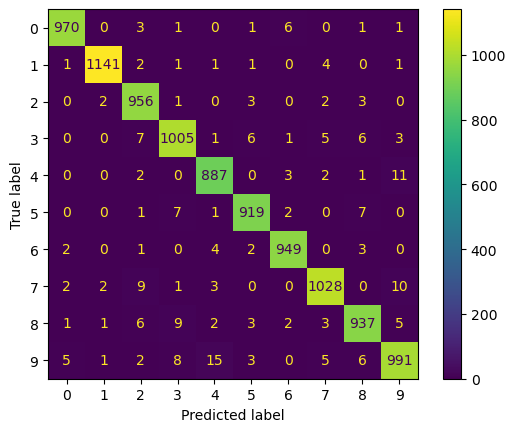

In [40]:
display_confusion_matrix(y_test, test_pred)

In [41]:
#save the model using joblib
from joblib import dump
dump(svm_final, 'svm_final.joblib')

['svm_final.joblib']

In [42]:
#also save the pipeline
dump(preprocess_pipe, 'preprocess_pipe.joblib')

['preprocess_pipe.joblib']